# Import 

In [920]:
# Data structure libaries
import pandas as pd
import numpy as np

# ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.neighbors import KernelDensity

# Math libraries
from statistics import mean 

# Visualization libraries
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load Dataset

In [985]:
sleep_data = pd.read_csv('./Data/processed_data_II.csv')

In [990]:
print(len(sleep_data))
print(len(sleep_data[sleep_data['sleep_disorder'] == 1]))
print(len(sleep_data[sleep_data['sleep_disorder'] == 0]))

1136
805
331


# Data Preprocessing (Normalization)

In [922]:
def normalize_feature(feature_to_normalize, max_val, min_val) :
    feature_length = len(feature_to_normalize)
    normalized = []
    for i in range(feature_length) :
        normalized.append(((feature_to_normalize[i] - min_val) / (max_val - min_val)))
    return normalized

In [923]:
# Removing unnamed column
sleep_data = sleep_data.loc[:, ~sleep_data.columns.str.contains('^Unnamed')]

In [924]:
# Removing SEQN
sleep_data = sleep_data.loc[:, ~sleep_data.columns.str.contains('SEQN')]

In [925]:
# Rearrange columns
new_cols = ['RIAGENDR', 'RIDAGEYR', 'SLQ040', 'SLQ050', 'DPQ020', 'DPQ030', 'DPQ040', 'BMXBMI',
                      'DR1IMAGN', 'DR1IIRON', 'DR1ISFAT', 'DR1IPFAT', 'DR1IMFAT', 
                      'DR2IMAGN', 'DR2IIRON', 'DR2ISFAT', 'DR2IPFAT', 'DR2IMFAT',
                      'SLD012', 'SLQ120', 'sleep_disorder']

sleep_data = sleep_data[new_cols]

# Normalize data
maxList = sleep_data.max()
minList = sleep_data.min()

# Lists that store the normalized values
RIAGENDR_norm = normalize_feature(sleep_data['RIAGENDR'].values.tolist(), maxList[0], minList[0])
RIDAGEYR_norm = normalize_feature(sleep_data['RIDAGEYR'].values.tolist(), maxList[1], minList[1])
SLQ040_norm = normalize_feature(sleep_data['SLQ040'].values.tolist(), maxList[2], minList[2])
SLQ050_norm = normalize_feature(sleep_data['SLQ050'].values.tolist(), maxList[3], minList[3])

DPQ020_norm = normalize_feature(sleep_data['DPQ020'].values.tolist(), maxList[4], minList[4])
DPQ030_norm = normalize_feature(sleep_data['DPQ030'].values.tolist(), maxList[5], minList[5])
DPQ040_norm = normalize_feature(sleep_data['DPQ040'].values.tolist(), maxList[6], minList[6])

BMXBMI_norm = normalize_feature(sleep_data['BMXBMI'].values.tolist(), maxList[7], minList[7])

DR1IMAGN_norm = normalize_feature(sleep_data['DR1IMAGN'].values.tolist(), maxList[8], minList[8])
DR1IIRON_norm = normalize_feature(sleep_data['DR1IIRON'].values.tolist(), maxList[9], minList[9])

DR1ISFAT_norm = normalize_feature(sleep_data['DR1ISFAT'].values.tolist(), maxList[10], minList[10])
DR1IPFAT_norm = normalize_feature(sleep_data['DR1IPFAT'].values.tolist(), maxList[11], minList[11])
DR1IMFAT_norm = normalize_feature(sleep_data['DR1IMFAT'].values.tolist(), maxList[12], minList[12])
DR2IMAGN_norm = normalize_feature(sleep_data['DR2IMAGN'].values.tolist(), maxList[13], minList[13])

DR2IIRON_norm = normalize_feature(sleep_data['DR2IIRON'].values.tolist(), maxList[14], minList[14])
DR2ISFAT_norm = normalize_feature(sleep_data['DR2ISFAT'].values.tolist(), maxList[15], minList[15])
DR2IPFAT_norm = normalize_feature(sleep_data['DR2IPFAT'].values.tolist(), maxList[16], minList[16])
DR2IMFAT_norm = normalize_feature(sleep_data['DR2IMFAT'].values.tolist(), maxList[17], minList[17])

SLD012_norm = normalize_feature(sleep_data['SLD012'].values.tolist(), maxList[18], minList[18])
SLQ120_norm = normalize_feature(sleep_data['SLQ120'].values.tolist(), maxList[19], minList[19])

sleep_disorder_norm = normalize_feature(sleep_data['sleep_disorder'].values.tolist(), maxList[20], minList[20])

# Create a new dataframe with the normalized values
normalized_features = {
         'RIAGENDR': RIAGENDR_norm,
         'RIDAGEYR': RIDAGEYR_norm, 
         'SLQ040': SLQ040_norm,
         'SLQ050': SLQ050_norm,
         'DPQ020': DPQ020_norm,
         'DPQ030': DPQ030_norm,
         'DPQ040': DPQ040_norm,
         'BMXBMI': BMXBMI_norm,
         'DR1IMAGN': DR1IMAGN_norm,
         'DR1IIRON': DR1IIRON_norm, 
         'DR1ISFAT': DR1ISFAT_norm,
         'DR1IPFAT': DR1IPFAT_norm,
         'DR1IMFAT': DR1IMFAT_norm,
         'DR2IMAGN': DR2IMAGN_norm,
         'DR2IIRON': DR2IIRON_norm, 
         'DR2ISFAT': DR2ISFAT_norm,
         'DR2IPFAT': DR2IPFAT_norm,
         'DR2IMFAT': DR2IMFAT_norm,
         'SLD012': SLD012_norm,
         'SLQ120': SLQ120_norm,
         'sleep_disorder': sleep_disorder_norm}

In [926]:
# Convert dictionary into dataframe
norm_df = pd.DataFrame.from_dict(normalized_features)

In [927]:
# Drop columns that are already hot encoded, or not helpful
norm_df = norm_df.drop(columns=['RIAGENDR', 'SLQ040', 'SLQ050', 'DPQ030'])

In [928]:
print(norm_df.columns)

Index(['RIDAGEYR', 'DPQ020', 'DPQ040', 'BMXBMI', 'DR1IMAGN', 'DR1IIRON',
       'DR1ISFAT', 'DR1IPFAT', 'DR1IMFAT', 'DR2IMAGN', 'DR2IIRON', 'DR2ISFAT',
       'DR2IPFAT', 'DR2IMFAT', 'SLD012', 'SLQ120', 'sleep_disorder'],
      dtype='object')


# Train - Validation Split

In [929]:
# All feature data
features = norm_df.iloc[:,:-1]
# All label data
labels = norm_df.iloc[:,-1:]

# Using the remaining training records, split into validation, slightly larger split to make it comparable to test size
og_feature_train, feature_val, og_label_train, label_val = train_test_split(features, labels, test_size=0.15, stratify=labels)


# In the end, we get 3 groups:

# feature_train
# label_train

# feature_test
# label_test

# feature_validation
# label_validation

# Kernel Density Estimation (Rank Removal)

In [930]:
def rank_removal(x_train, y_train, feature_col, y_col, rank_threshold) :
    '''
        :param x_train: the np array of learning data
        :param y_train: the np array of labels for learning data
        :param feature_col: actual column names []
        :param y_col: the label column
        :param rank_threshold: the percentage of data we want to drop (like 0.30 to keep the top 70% of the data)
        :returns x_train_df, y_train_df, x_train, y_train, rows_to_drop: returns the dataframe versions of the remaining rows after removal, as well as the indicies of the rows dropped
    '''
    # Convert to 2d tabular data
    x_train_df = pd.DataFrame(x_train, columns = feature_col)
    y_train_df = pd.DataFrame(y_train, columns = [y_col])
    
    # Fit the data for the kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(x_train_df)
    # Caculate the probability density 
    logprob = kde.score_samples(x_train_df)

    # Drop the bottom k%, keeping the top k%
    perc = rank_threshold
    perc = int(len(logprob) * perc)

    print('Drop Bottom ' + str(rank_threshold * 100) + '%')
    rows_to_drop = np.argpartition(logprob, perc)[:perc]
    print('Number of rows dropped: ', str(len(rows_to_drop)))
    
    x_train_df = x_train_df.drop(rows_to_drop, axis=0)
    y_train_df = y_train_df.drop(rows_to_drop, axis=0)
    
    return x_train_df, y_train_df, rows_to_drop

In [931]:
feature_col = ['RIDAGEYR', 'DPQ020', 'DPQ040', 'BMXBMI', 'DR1IMAGN', 'DR1IIRON', 'DR1ISFAT',
               'DR1IPFAT', 'DR1IMFAT', 'DR2IMAGN', 'DR2IIRON', 'DR2ISFAT', 'DR2IPFAT',
               'DR2IMFAT', 'SLD012', 'SLQ120']
y_col = ['sleep_disorder']

In [932]:
# Specify the bottom % to drop
rank_threshold = 0.60
feature_train, label_train, rows_dropped = rank_removal(np.array(og_feature_train), np.array(og_label_train), feature_col, y_col, rank_threshold)

Drop Bottom 60.0%
Number of rows dropped:  579


# Hyperparameter Tuning 

In [933]:
# The maximum depth allowed. Generally, if the depth is too low we will underfit. If it is too high we will overfit 
n_trees = list(range(1,100))
best_param = []

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Iterate over values of num_trees to find best fit
for n in n_trees :
    param_dist = {'n_estimators': [n], 'max_depth': randint(1,10)}

    # Create a random forest classifier
    model = RandomForestClassifier()

    # Use random search to find the best hyperparameters
    rand_search = RandomizedSearchCV(model, param_distributions = param_dist, n_iter=3, cv=3)

    # Fit the random search object to the data
    rand_search.fit(feature_train, label_train.values.ravel())
    
    # Create a variable for the best model
    best_param.append(rand_search.best_params_)
    
    accuracy_list.append(accuracy_score(label_val, rand_search.predict(feature_val)))
    precision_list.append(precision_score(label_val, rand_search.predict(feature_val)))
    recall_list.append(recall_score(label_val, rand_search.predict(feature_val)))
    f1_list.append(f1_score(label_val, rand_search.predict(feature_val)))
    

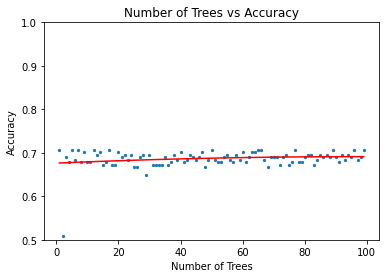

In [909]:
plt.scatter(n_trees, accuracy_list, s=5)
plt.title('Number of Trees vs Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)

# Calculate equation for trendline
z = np.polyfit(n_trees, accuracy_list, 2)
p = np.poly1d(z)

plt.plot(n_trees, p(n_trees), color='red')

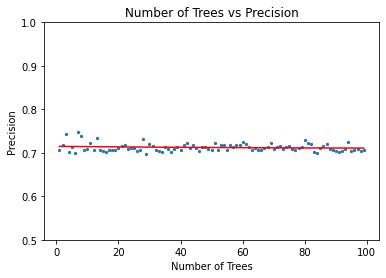

In [889]:
plt.scatter(n_trees, precision_list, s=5)
plt.title('Number of Trees vs Precision')
plt.xlabel('Number of Trees')
plt.ylabel('Precision')
plt.ylim(0.5, 1.0)

# Calculate equation for trendline
z = np.polyfit(n_trees, precision_list, 2)
p = np.poly1d(z)

plt.plot(n_trees, p(n_trees), color='red')

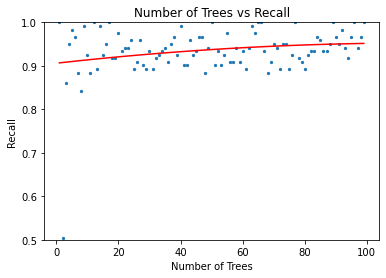

In [890]:
plt.scatter(n_trees, recall_list, s=5)
plt.title('Number of Trees vs Recall')
plt.xlabel('Number of Trees')
plt.ylabel('Recall')
plt.ylim(0.5, 1.0)

# Calculate equation for trendline
z = np.polyfit(n_trees, recall_list, 2)
p = np.poly1d(z)

plt.plot(n_trees, p(n_trees), color='red')

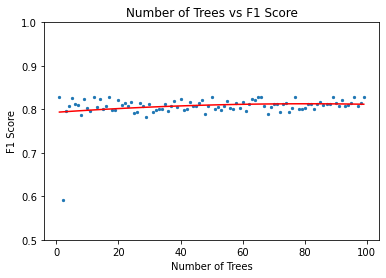

In [892]:
plt.scatter(n_trees, f1_list, s=5)
plt.title('Number of Trees vs F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('F1 Score')
plt.ylim(0.5, 1.0)

# Calculate equation for trendline
z = np.polyfit(n_trees, f1_list, 2)
p = np.poly1d(z)

plt.plot(n_trees, p(n_trees), color='red')

In [884]:
index = (accuracy_list.index(max(accuracy_list)))
best_n_tree = best_param[index]['n_estimators']
best_max_depth = best_param[index]['max_depth']
print('Best Number of Decision Trees: ', best_n_tree + 1)
print('Best Maximum Depth: ', best_max_depth + 1)
print('Best Accuracy: ', max(accuracy_list))
print('Average Accuracy: ', mean(accuracy_list))

Best Number of Decision Trees:  13
Best Maximum Depth:  5
Best Accuracy:  0.7251461988304093
Average Accuracy:  0.682615629984051


In [ ]:
index = (precision_list.index(max(precision_list)))
best_n_tree = best_param[index]['n_estimators']
best_max_depth = best_param[index]['max_depth']
print('Best Number of Decision Trees: ', best_n_tree + 1)
print('Best Maximum Depth: ', best_max_depth + 1)
print('Best Precision: ', max(precision_list))
print('Average Precision: ', mean(precision_list))

In [ ]:
index = (recall_list.index(max(recall_list)))
best_n_tree = best_param[index]['n_estimators']
best_max_depth = best_param[index]['max_depth']
print('Best Number of Decision Trees: ', best_n_tree + 1)
print('Best Maximum Depth: ', best_max_depth + 1)
print('Best Recall: ', max(recall_list))
print('Average Recall: ', mean(recall_list))

In [ ]:
index = (f1_list.index(max(f1_list)))
best_n_tree = best_param[index]['n_estimators']
best_max_depth = best_param[index]['max_depth']
print('Best Number of Decision Trees: ', best_n_tree + 1)
print('Best Maximum Depth: ', best_max_depth + 1)
print('Best F1 Score: ', max(f1_list))
print('Average F1 Score: ', mean(f1_list))

# Random Forest 

In [952]:
feature_train_dump, feature_test, label_train_dump, label_test = train_test_split(og_feature_train, og_label_train, test_size=0.2)

In [953]:
# Consistently been around:
# best_n_tree = 45
# best_max_depth = 5

# Create model 
model = RandomForestClassifier(n_estimators = 45, max_depth = best_max_depth, random_state = 1)
# Train the model on training data
model.fit(feature_train, label_train.values.ravel());
# Predict labels over the test data
y_pred = model.predict(feature_test)
# Evaluate accuracy over the testing data
accuracy = accuracy_score(label_test, model.predict(feature_test))

In [954]:
print(accuracy)

0.7979274611398963


# Interpret Results

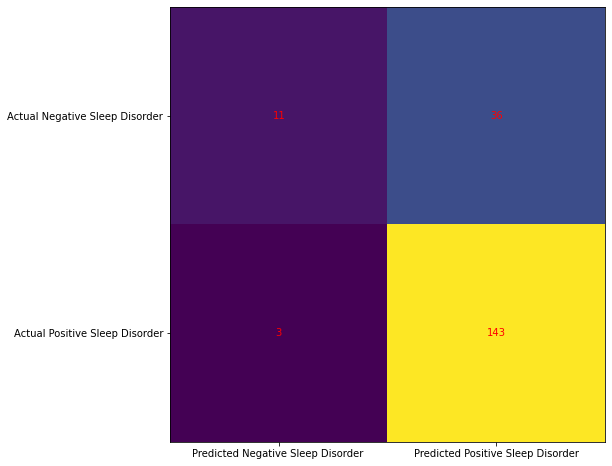

In [955]:
# Create the confusion matrix
cm = confusion_matrix(label_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Negative Sleep Disorder ', 'Predicted Positive Sleep Disorder'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Negative Sleep Disorder', 'Actual Positive Sleep Disorder'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [962]:
report = classification_report(label_test, y_pred, output_dict=True)
classification_report(label_test, y_pred, output_dict=True)

{'0.0': {'precision': 0.7857142857142857,
  'recall': 0.23404255319148937,
  'f1-score': 0.36065573770491804,
  'support': 47},
 '1.0': {'precision': 0.7988826815642458,
  'recall': 0.9794520547945206,
  'f1-score': 0.88,
  'support': 146},
 'accuracy': 0.7979274611398963,
 'macro avg': {'precision': 0.7922984836392657,
  'recall': 0.6067473039930049,
  'f1-score': 0.620327868852459,
  'support': 193},
 'weighted avg': {'precision': 0.7956758701396441,
  'recall': 0.7979274611398963,
  'f1-score': 0.7535275630680369,
  'support': 193}}

In [963]:
macro_precision =  report['0.0']['precision'] 
macro_recall = report['macro avg']['recall']    
macro_f1 = report['macro avg']['f1-score']

print(macro_precision)
print(macro_recall)
print(macro_f1)

0.7857142857142857
0.6067473039930049
0.620327868852459


# Driver (to run entire experiment over k iterations, if needed)

In [964]:

avg_acc = []

avg_prec_maj = []
avg_recall_maj = []
avg_f1_maj = []

avg_prec_min = []
avg_recall_min = []
avg_f1_min = []

for i in range (50) :
    feature_train_dump, feature_test, label_train_dump, label_test = train_test_split(og_feature_train, og_label_train, test_size=0.15)

    
    # Create model 
    model = RandomForestClassifier(n_estimators = 45, max_depth = best_max_depth, random_state = 1)
    # Train the model on training data
    model.fit(feature_train, label_train.values.ravel());
    # Predict labels over the test data
    model.predict(feature_test)
    
    report = classification_report(label_test, model.predict(feature_test), output_dict=True)
    
    # Evaluate accuracy over the testing data
    avg_acc.append(report['accuracy'])
    
    
    maj_precision = report['1.0']['precision'] 
    maj_recall = report['1.0']['recall']    
    maj_f1 = report['1.0']['f1-score']
    
    min_precision = report['0.0']['precision'] 
    min_recall = report['0.0']['recall']    
    min_f1 = report['0.0']['f1-score']
    
    avg_prec_maj.append(maj_precision)
    avg_recall_maj.append(maj_recall)
    avg_f1_maj.append(maj_f1)
    
    avg_prec_min.append(min_precision)
    avg_recall_min.append(min_recall)
    avg_f1_min.append(min_f1)
    
    #print(classification_report(label_test, model.predict(feature_test)))


In [965]:
print(mean(avg_acc))
print(mean(avg_prec_maj))
print(mean(avg_recall_maj))
print(mean(avg_f1_maj))
print(mean(avg_prec_min))
print(mean(avg_recall_min))
print(mean(avg_f1_min))

0.7455172413793103
0.7513821942775336
0.961539853273806
0.8430221968511101
0.6768462376976309
0.2042108726214108
0.3103949107000457


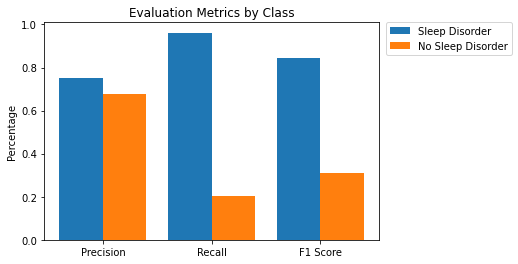

In [982]:
# Saved mean metrics from i = 20 iterations above
X = ['Precision','Recall','F1 Score'] 
majority = [mean(avg_prec_maj), mean(avg_recall_maj), mean(avg_f1_maj)] 
minority = [mean(avg_prec_min), mean(avg_recall_min), mean(avg_f1_min)] 
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, majority, 0.4, label = 'Sleep Disorder') 
plt.bar(X_axis + 0.2, minority, 0.4, label = 'No Sleep Disorder') 
  
plt.xticks(X_axis, X) 
plt.ylabel('Percentage') 
plt.title('Evaluation Metrics by Class') 
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0) 
plt.show() 

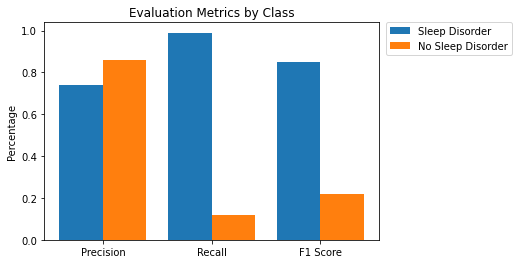

In [991]:
# For SVM: Saved mean metrics from i = 20 iterations above
X = ['Precision','Recall','F1 Score'] 
majority = [0.74, 0.99, 0.85] 
minority = [0.86, 0.12, 0.22] 
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, majority, 0.4, label = 'Sleep Disorder') 
plt.bar(X_axis + 0.2, minority, 0.4, label = 'No Sleep Disorder') 
  
plt.xticks(X_axis, X) 
plt.ylabel('Percentage') 
plt.title('Evaluation Metrics by Class') 
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0) 
plt.show() 